In [2]:
import uproot
import matplotlib.pyplot as plt
import numpy as np
import awkward as ak
from particle import Particle, InvalidParticle, ParticleNotFound
import pdg
api = pdg.connect()


## Initial FASERv studies with GENIE

I used the [GenieGenerator](https://gitlab.cern.ch/faser/offline/geniegenerator) repo from the FASER offline software to generate $1 \textrm{fb}^-1$ worth of neutrino interactions
I used the [`/GenieGenerator/faser/runGenerator_1.sh`](https://gitlab.cern.ch/faser/offline/geniegenerator/-/blob/faser-R-3_00_06/faser/runGenerator_1.sh?ref_type=heads) script, which I believe simulates all possible $\nu_e$, $\nu_\mu$ and $\nu_\tau$ interactions for a given geometry

For the current FASERv model I used the [`FaserNu3.gdml`](https://gitlab.cern.ch/faser/offline/geniegenerator/-/blob/faser-R-3_00_06/faser/Geometry/FaserNu3.gdml?ref_type=heads) file (The default in the run script)

For the FASERvSi model I used a simple detector comprised of 132 layers of tungsten sheets $25 \times 30 \times 0.9$ cm in volume (171.5 kg assuming tungsten density of 19.25 g/cm3)

In [3]:
faserv_current = uproot.open("../GenieOutput/FaserNu3-1fb.0.gfaser.root:gFaser")
print(faserv_current.keys())

['vx', 'vy', 'vz', 'n', 'name', 'pdgc', 'status', 'firstMother', 'lastMother', 'firstDaughter', 'lastDaughter', 'px', 'py', 'pz', 'E', 'm', 'M']


In [4]:
kinematics = faserv_current.arrays(faserv_current.keys(), library='np')    

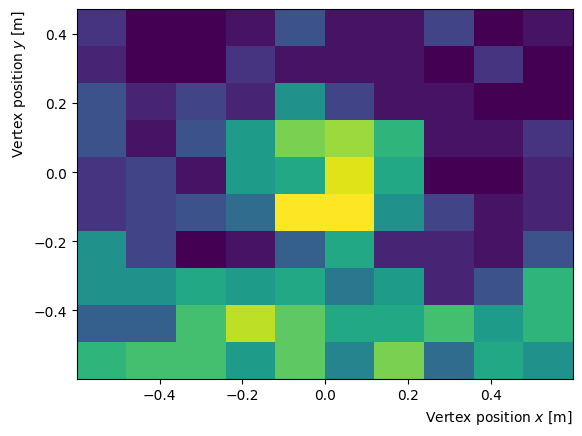

In [5]:
fig, ax = plt.subplots()
ax.hist2d(kinematics['vx'], kinematics['vy']);
ax.set_xlabel(r"Vertex position $x$ [m]", loc="right");
ax.set_ylabel(r"Vertex position $y$ [m]", loc="top");

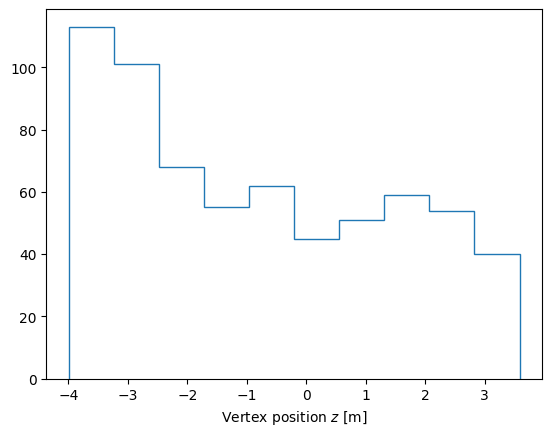

In [6]:
fig, ax = plt.subplots()
ax.hist(kinematics["vz"], histtype='step');
ax.set_xlabel(r"Vertex position $z$ [m]");

In [7]:
pdg_code_dict = {1: "down",
                 2: "up",
                 3: "strange",
                 4: "charm",
                 5: "bottom",
                 6: "top",
                 7: "bottom'",
                 8: "top'",
                 9: "gluon (glueball)",
                 10: "not defined",
                 11: "electron",
                 12: "electron-neutrino",
                 13: "muon",
                 14: "muon-neutrino",
                 15: "tau",
                 16: "tau-neutrino",
                 17: "tau'",
                 18: "tau-neutrino'",
                 19: "not defined",                 
                 }

genie_status_code_dict = {-1: "undefined",
                          0: "initial state",
                          1: "stable final state",
                          2: "intermediate state",
                          3: "decayed state",
                          11: "nucleon target",
                          12: "DIS pre-fragmentation state",
                          13: "resonant pre-decayed state",
                          14: "hadron in nucleus",
                          15: "nuclear final state remnant",
                          16: "nucleon cluster target"}

In [8]:
def get_name_from_pdgc(pdgc):
    try:
        particle = Particle.from_pdgid(abs(pdgc))
        
        particle_name = particle.name
        
        if pdgc < 0 and "+" not in particle_name and "-" not in particle_name:
            particle_name = f"anti-{particle_name}"
        
        return particle_name
        
    except InvalidParticle:
        return f"Unknown PDG Code: {pdgc}"
    except ParticleNotFound:
        return f"Particle not found: {pdgc}"

In [9]:
i = 3
for pdgc, status in zip(kinematics["pdgc"][i], kinematics["status"][i]):
    print(f"pdg: {get_name_from_pdgc(pdgc)} --- status: {genie_status_code_dict[status]}")


pdg: nu(e) --- status: initial state
pdg: Fe56 --- status: initial state
pdg: n --- status: nucleon target
pdg: Fe55 --- status: intermediate state
pdg: nu(e) --- status: stable final state
pdg: Unknown PDG Code: 2000000001 --- status: DIS pre-fragmentation state
pdg: u --- status: DIS pre-fragmentation state
pdg: (dd)(1) --- status: DIS pre-fragmentation state
pdg: Particle not found: 92 --- status: DIS pre-fragmentation state
pdg: pi+ --- status: hadron in nucleus
pdg: pi+ --- status: hadron in nucleus
pdg: pi+ --- status: hadron in nucleus
pdg: Delta(1232)0 --- status: DIS pre-fragmentation state
pdg: rho(770)+ --- status: DIS pre-fragmentation state
pdg: Delta(1232)- --- status: DIS pre-fragmentation state
pdg: Delta(1232)- --- status: DIS pre-fragmentation state
pdg: p --- status: hadron in nucleus
pdg: pi+ --- status: hadron in nucleus
pdg: pi+ --- status: hadron in nucleus
pdg: pi0 --- status: hadron in nucleus
pdg: anti-n --- status: hadron in nucleus
pdg: pi+ --- status: hadro

In [10]:
initial_states = []
neutrino_set = set()
nucleus_set = set()

for i in range(len(kinematics["pdgc"])):
    tmp = []
    for pdgc, status in zip(kinematics["pdgc"][i], kinematics["status"][i]):
        if status == 0:
            tmp.append(get_name_from_pdgc(pdgc))

    tmp.append([kinematics['vx'][i], kinematics['vy'][i], kinematics['vz'][i]])
    neutrino_set.add(tmp[0])
    nucleus_set.add(tmp[1])
    initial_states.append(tmp)
    
print(sorted(neutrino_set))
print(sorted(nucleus_set))

['anti-nu(e)', 'anti-nu(mu)', 'anti-nu(tau)', 'nu(e)', 'nu(mu)', 'nu(tau)']
['Al27', 'B11', 'C12', 'Ca40', 'Ca43', 'Ca48', 'Cr52', 'Fe54', 'Fe56', 'Fe57', 'K39', 'K41', 'N14', 'Na23', 'Nd142', 'Nd143', 'Nd144', 'Nd145', 'Nd146', 'Nd148', 'Nd150', 'O16', 'Pb206', 'Pb207', 'Pb208', 'Si28', 'Si29', 'Si30', 'W182', 'W183', 'W184', 'W186', 'p']


In [11]:
neutrino_dict = {value: {"count": 0, "vx": [], "vy": [], "vz": []} for value in sorted(neutrino_set)}
nucleus_dict = {value: {"count": 0, "vx": [], "vy": [], "vz": []} for value in sorted(nucleus_set)}

for (neutrino, nucleus, (vx, vy, vz)) in initial_states:
    neutrino_dict[neutrino]["count"] += 1
    neutrino_dict[neutrino]["vx"].append(vx)
    neutrino_dict[neutrino]["vy"].append(vy)
    neutrino_dict[neutrino]["vz"].append(vz)
    
    nucleus_dict[nucleus]["count"] += 1
    nucleus_dict[nucleus]["vx"].append(vx)
    nucleus_dict[nucleus]["vy"].append(vy)
    nucleus_dict[nucleus]["vz"].append(vz)

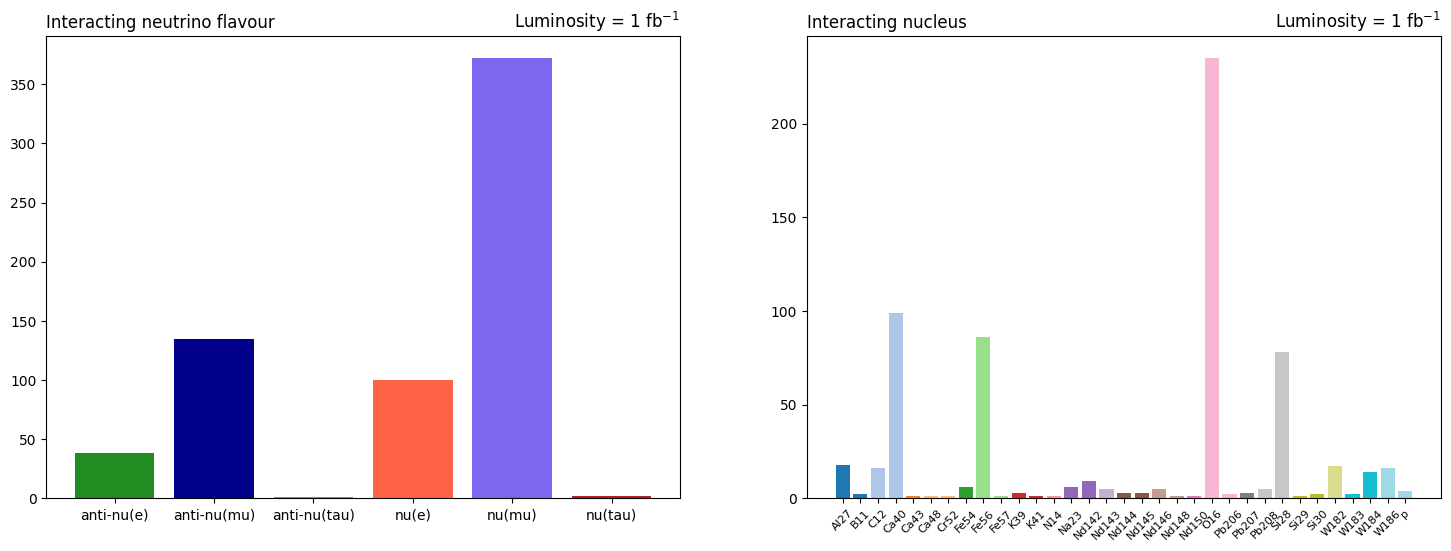

In [12]:
fig, ax = plt.subplots(ncols=2, figsize=(18, 6))

neutrino_labels = neutrino_dict.keys()
neutrino_count = [c["count"] for c in neutrino_dict.values()]


nucleus_labels =nucleus_dict.keys()
nucleus_count = [c["count"] for c in nucleus_dict.values()]

ax[0].set_title("Interacting neutrino flavour", loc='left')
ax[0].set_title(r"Luminosity = 1 $\text{fb}^{-1}$", loc='right')
ax[0].bar(range(len(neutrino_labels)), neutrino_count, tick_label=neutrino_labels, color=["forestgreen", "darkblue", "limegreen", "tomato", "mediumslateblue", "firebrick"])

colors = plt.cm.tab20(np.linspace(0, 1, len(nucleus_labels)))

ax[1].set_title("Interacting nucleus", loc='left')
ax[1].set_title(r"Luminosity = 1 $\text{fb}^{-1}$", loc='right')
ax[1].bar(range(len(nucleus_labels)), nucleus_count, tick_label=nucleus_labels, color=colors);
ax[1].set_xticks(range(len(nucleus_labels)), rotation=45, labels=nucleus_labels, fontsize=8);

plt.savefig("FaserNu3.gdml-1fb-dominant-interactions.pdf")

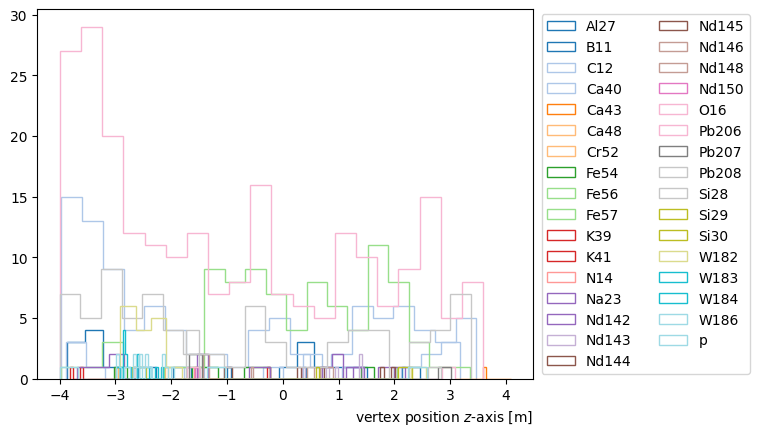

In [13]:
fig, ax = plt.subplots()

colors = plt.cm.tab20(np.linspace(0, 1, len(nucleus_labels)))

for i, (nucleus_name, nucleus_data) in enumerate(nucleus_dict.items()):
    ax.hist(nucleus_data['vz'], 20, label=nucleus_name, histtype="step", color=colors[i])

ax.legend(ncols=2, loc='center right', bbox_to_anchor=(1.45, 0.5))
ax.set_xlabel(r"vertex position $z$-axis [m]", loc="right")
plt.savefig("FaserNu3.gdml-nuclus-zpos.pdf")
     

Total number of events in FASERv: 48


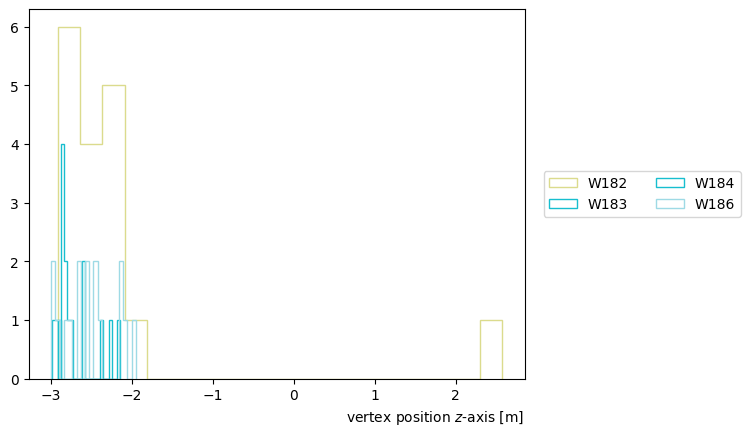

In [14]:
fig, ax = plt.subplots()

colors = plt.cm.tab20(np.linspace(0, 1, len(nucleus_labels)))

total_events_in_faserv = 0

for i, (nucleus_name, nucleus_data) in enumerate(nucleus_dict.items()):
    if "W" in nucleus_name:
        ax.hist(nucleus_data['vz'], 20, label=nucleus_name, histtype="step", color=colors[i])
        
        for vz in nucleus_data['vz']:
            if vz < -1:
                total_events_in_faserv += 1 
        
ax.legend(ncols=2, loc='center right', bbox_to_anchor=(1.45, 0.5))
ax.set_xlabel(r"vertex position $z$-axis [m]", loc="right")
plt.savefig("FaserNu3.gdml-tungsten-zpos.pdf")

# That last peak is presumably the preshower (it has a tungsten layer)

print(f"Total number of events in FASERv: {total_events_in_faserv}")
     

Text(1, 0, 'vertex position $z$-axis [m]')

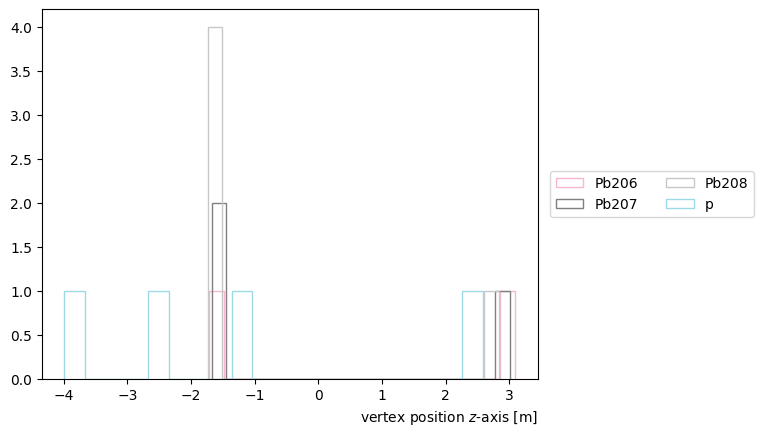

In [15]:
fig, ax = plt.subplots()

colors = plt.cm.tab20(np.linspace(0, 1, len(nucleus_labels)))

for i, (nucleus_name, nucleus_data) in enumerate(nucleus_dict.items()):
    if "p" in nucleus_name or "Pb" in nucleus_name:
        ax.hist(nucleus_data['vz'], 20, label=nucleus_name, histtype="step", color=colors[i])

ax.legend(ncols=2, loc='center right', bbox_to_anchor=(1.45, 0.5))
ax.set_xlabel(r"vertex position $z$-axis [m]", loc="right")
# plt.savefig("FaserNu3.gdml-tungsten-zpos.pdf")
     

Text(1, 0, 'vertex position $z$-axis [m]')

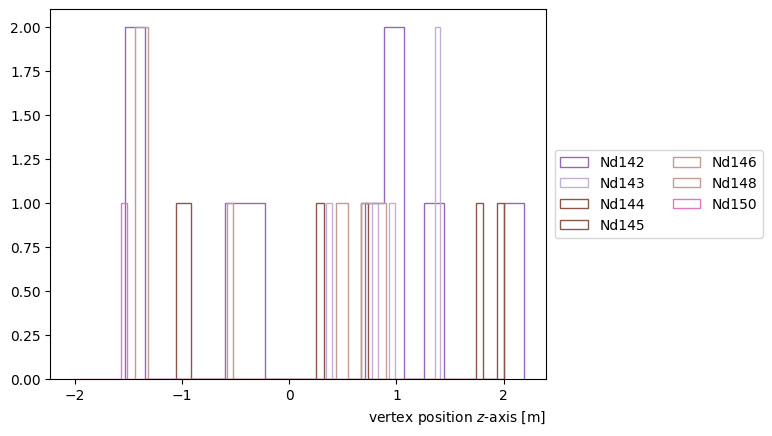

In [16]:
fig, ax = plt.subplots()

colors = plt.cm.tab20(np.linspace(0, 1, len(nucleus_labels)))

for i, (nucleus_name, nucleus_data) in enumerate(nucleus_dict.items()):
    if "Nd" in nucleus_name:
        ax.hist(nucleus_data['vz'], 20, label=nucleus_name, histtype="step", color=colors[i])

ax.legend(ncols=2, loc='center right', bbox_to_anchor=(1.45, 0.5))
ax.set_xlabel(r"vertex position $z$-axis [m]", loc="right")
# plt.savefig("FaserNu3.gdml-tungsten-zpos.pdf")
     

Text(1, 0, 'vertex position $z$-axis [m]')

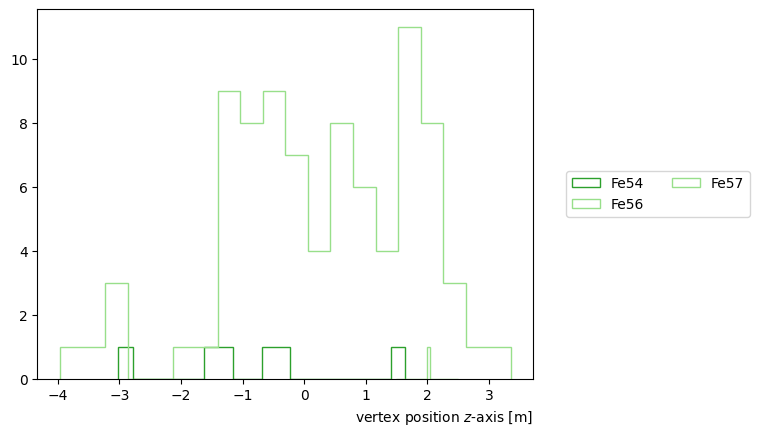

In [17]:
fig, ax = plt.subplots()

colors = plt.cm.tab20(np.linspace(0, 1, len(nucleus_labels)))

for i, (nucleus_name, nucleus_data) in enumerate(nucleus_dict.items()):
    if "Fe" in nucleus_name:
        ax.hist(nucleus_data['vz'], 20, label=nucleus_name, histtype="step", color=colors[i])

ax.legend(ncols=2, loc='center right', bbox_to_anchor=(1.45, 0.5))
ax.set_xlabel(r"vertex position $z$-axis [m]", loc="right")
# plt.savefig("FaserNu3.gdml-tungsten-zpos.pdf")
     

Text(1, 0, 'vertex position $z$-axis [m]')

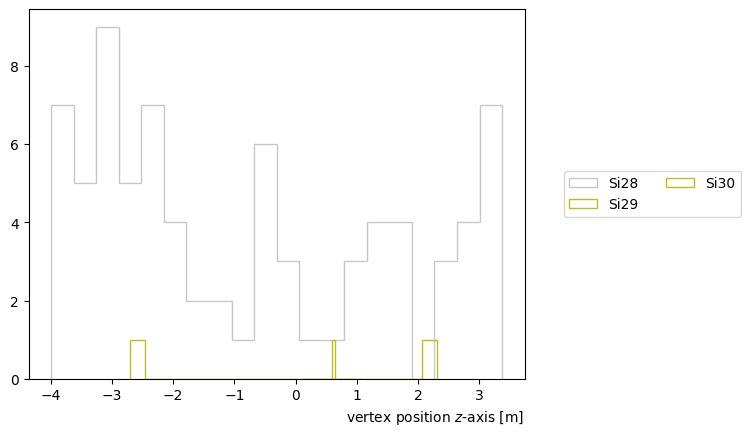

In [18]:
fig, ax = plt.subplots()

colors = plt.cm.tab20(np.linspace(0, 1, len(nucleus_labels)))

for i, (nucleus_name, nucleus_data) in enumerate(nucleus_dict.items()):
    if "Si" in nucleus_name:
        ax.hist(nucleus_data['vz'], 20, label=nucleus_name, histtype="step", color=colors[i])

ax.legend(ncols=2, loc='center right', bbox_to_anchor=(1.45, 0.5))
ax.set_xlabel(r"vertex position $z$-axis [m]", loc="right")
# plt.savefig("FaserNu3.gdml-tungsten-zpos.pdf")
     